<a href="https://colab.research.google.com/github/Entro01/ML-starter/blob/main/makemore/makemore_MLP/makrmore_MLP_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [52]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [53]:
# building the vocabulary of characters

chrs = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i,s in enumerate(chrs)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [54]:
#building the dataset

block_size = 3 #context length (was 1 in bigram model)
X, Y = [], []

for w in words[:5]:
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', ch)
    context = context[1:]
    context.append(ix)
X = torch.tensor(X)
Y = torch.tensor(Y)
num = int(X.nelement() / block_size)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [55]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

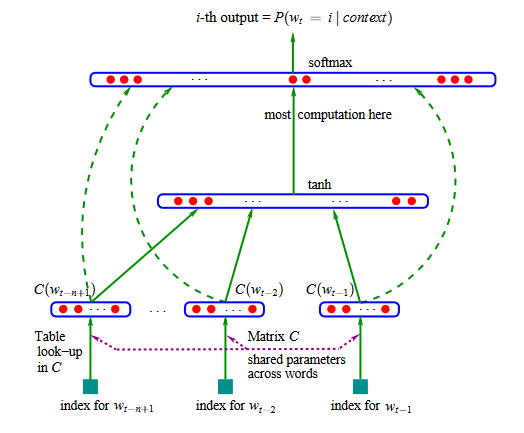

In [56]:
g = torch.Generator().manual_seed(2147483647)

In [57]:
# first layer
C = torch.randn(27,2, generator = g)
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [68]:
# second layer
W1 = torch.randn(6, 100, generator = g)
B1 = torch.randn(100, generator = g)

h = torch.tanh(emb.view(num, 6) @ W1 + B1)
# tanh is the activation function
# .view is used to represents the emb matrix in a (32, 6) shape

h.shape

torch.Size([32, 100])

In [69]:
# final layer
W2 = torch.randn(100, 27, generator = g)
B2 = torch.randn(27, generator = g)

logits = h @ W2 + B2 # log counts
counts = logits.exp() # counts
probs = counts / counts.sum(1, keepdims = True) #probabilities
probs.shape

torch.Size([32, 27])

In [70]:
# loss
loss = -probs[torch.arange(num), Y].log().mean()
loss

tensor(12.8585)

In [71]:
parameters= [C, W1, B1, W2, B2]

sum(p.nelement() for p in parameters)

3481

In [72]:
# calculating loss more efficiently

logits = h @ W2 + B2 # log counts
#counts = logits.exp() # counts
#probs = counts / counts.sum(1, keepdims = True) #probabilities

loss = F.cross_entropy(logits, Y)
loss
# this provides the exact same loss but is much more efficient
# it does not create new tensors in memory but uses operations with clustered kernels
# the backward pass is much more efficient
# the loss calculation is always numerically well behaved

tensor(12.8585)

In [75]:
# FINAL MODEL

In [157]:
#building the dataset

block_size = 3 #context length (was 1 in bigram model)
X, Y = [], []

for w in words:
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:]
    context.append(ix)
X = torch.tensor(X)
Y = torch.tensor(Y)
num = int(X.nelement() / block_size)

In [148]:
num

228146

In [158]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(27,2, generator = g)
W1 = torch.randn(6, 100, generator = g)
B1 = torch.randn(100, generator = g)
W2 = torch.randn(100, 27, generator = g)
B2 = torch.randn(27, generator = g)

parameters= [C, W1, B1, W2, B2]

for p in parameters:
  p.requires_grad = True

In [168]:
for i in range(10000):

  # creating a mini batch
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]]
  h = torch.tanh(emb.view(32, 6) @ W1 + B1)
  logits = h @ W2 + B2
  loss = F.cross_entropy(logits, Y[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.01 * p.grad


print("loss: ", loss.item())

loss:  2.1724331378936768


In [169]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Y)

loss

tensor(2.3153, grad_fn=<NllLossBackward0>)